In [37]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import csv
import numpy as np
import psycopg2
import pandas.io.sql as sqlio
import geopandas as gpd
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta

In [38]:
#Download Files "social_distancing.csv" and "tl_2019_27_tract.shp" by copy and pasting Google Drive link:
#https://drive.google.com/drive/folders/1gE-yFdIgpPjkAIj_EtumlrRvpQHs0514?usp=sharing
#Change the path variable as per the local machine address:
path = "/Users/arunsharma/Desktop/"
social_v2 = pd.read_csv(path+"social_distancing.csv")
social_v2 = social_v2.drop(['Unnamed: 0'], axis = 1)
social_v2['date_range_start']= pd.to_datetime(social_v2['date_range_start'])
social_v2['date_range_end']= pd.to_datetime(social_v2['date_range_end'])
mn_ct_shp = gpd.read_file('/Users/arunsharma/Desktop/mn_ct_shp/tl_2019_27_tract.shp')
metropolitan_county_fips = ['053', '163', '123', '139', '037', '003', '019']
metropolitan_ct_shp = mn_ct_shp.loc[mn_ct_shp['COUNTYFP'].isin(metropolitan_county_fips)]
metropolitan_ct_shp

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,27,037,060716,27037060716,607.16,Census Tract 607.16,G5020,S,3782370,293049,+44.8242729,-093.1831161,"POLYGON ((-93.19843 44.82719, -93.19711 44.828..."
1,27,037,060717,27037060717,607.17,Census Tract 607.17,G5020,S,11760284,545256,+44.8465754,-093.1305462,"POLYGON ((-93.16410 44.83360, -93.16134 44.837..."
2,27,037,060710,27037060710,607.10,Census Tract 607.10,G5020,S,10212239,358264,+44.7779970,-093.3059622,"POLYGON ((-93.32978 44.77802, -93.32967 44.778..."
3,27,037,060711,27037060711,607.11,Census Tract 607.11,G5020,S,3572710,30615,+44.7582405,-093.2810093,"POLYGON ((-93.28919 44.76076, -93.28894 44.765..."
4,27,037,060713,27037060713,607.13,Census Tract 607.13,G5020,S,2840388,54332,+44.7602474,-093.2664153,"POLYGON ((-93.27809 44.75543, -93.27778 44.755..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1319,27,037,061402,27037061402,614.02,Census Tract 614.02,G5020,S,212161993,3588573,+44.5716298,-092.9238254,"POLYGON ((-93.03937 44.54351, -93.03836 44.543..."
1320,27,037,060714,27037060714,607.14,Census Tract 607.14,G5020,S,4091432,192134,+44.7787565,-093.2391366,"POLYGON ((-93.24817 44.78180, -93.24815 44.783..."
1321,27,037,060813,27037060813,608.13,Census Tract 608.13,G5020,S,7798503,1750671,+44.7034713,-093.2991255,"POLYGON ((-93.31840 44.68705, -93.31837 44.687..."
1334,27,037,060709,27037060709,607.09,Census Tract 607.09,G5020,S,3773616,211132,+44.7590705,-093.3168753,"POLYGON ((-93.32873 44.76118, -93.32873 44.761..."


### Code for generating Figure 14 and Figure 17

In [39]:
def get_aggregated_df(df_new):
    df_new['distance_traveled_from_home'].replace('', np.nan, inplace=True)
    df_new.dropna(subset=['distance_traveled_from_home'], inplace=True)
    df_new['median_home_dwell_time'].replace('', np.nan, inplace=True)
    df_new.dropna(subset=['median_home_dwell_time'], inplace=True)
    df_new['ct_fips'] = df_new['origin_census_block_group'].astype(str).str.slice(stop=11)
    df_new['total_distance_traveled_from_home'] = df_new['distance_traveled_from_home'] * df_new['device_count']
    df_new['total_median_home_dwell_time'] = df_new['median_home_dwell_time'] * df_new['device_count']
    agg_df = df_new[['ct_fips', 'device_count', 'total_distance_traveled_from_home', 'total_median_home_dwell_time']].groupby('ct_fips').sum().reset_index()
    agg_df['avg_distance_traveled_from_home'] = agg_df['total_distance_traveled_from_home'] / agg_df['device_count']
    agg_df['avg_median_home_dwell_time'] = agg_df['total_median_home_dwell_time'] / agg_df['device_count']
    return agg_df[['ct_fips', 'device_count', 'avg_distance_traveled_from_home', 'avg_median_home_dwell_time']]

In [40]:
#Code to populate the global data from a given time range
date = datetime(2020,3,1,0,0,0)
# print (social_v2['date_range_start'].iloc[0] == date)
global_array = []
for i in range(407):
    date_start = date
    filtered_df = social_v2.loc[(social_v2['date_range_start'] == date_start)]
    out = get_aggregated_df(filtered_df)
    global_array.append(out)
    date += timedelta(days=1)

/Users/arunsharma/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
<ipython-input-39-88623ca54527>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new.dropna(subset=['distance_traveled_from_home'], inplace=True)
<ipython-input-39-88623ca54527>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new.dropna(subset=['median_home_dwell_ti

In [41]:
#Code to populate x-axis for a given time range
week_labels = ['03/01', '03/08', '03/15', '03/22', '03/29', '04/05', 
               '04/12', '04/19', '04/26', '05/03', '05/10', '05/17',
               '05/24', '05/31', '06/07', '06/14', '06/21', '06/28',
               '07/05', '07/12', '07/19', '07/26', '08/02', '08/09',
               '08/16', '08/23', '08/30', '09/06', '09/13', '09/20',
               '09/27', '10/04', '10/11', '10/18', '10/25', '11/01',
               '11/08', '11/15', '11/22', '11/29', '12/06', '12/13',
               '12/20', '12/27', '01/03', '01/10', '01/17', '01/24',
               '01/31', '02/07', '02/14', '02/21', '02/28', '03/07',
               '03/14', '03/21', '03/28', '04/04'
              ]

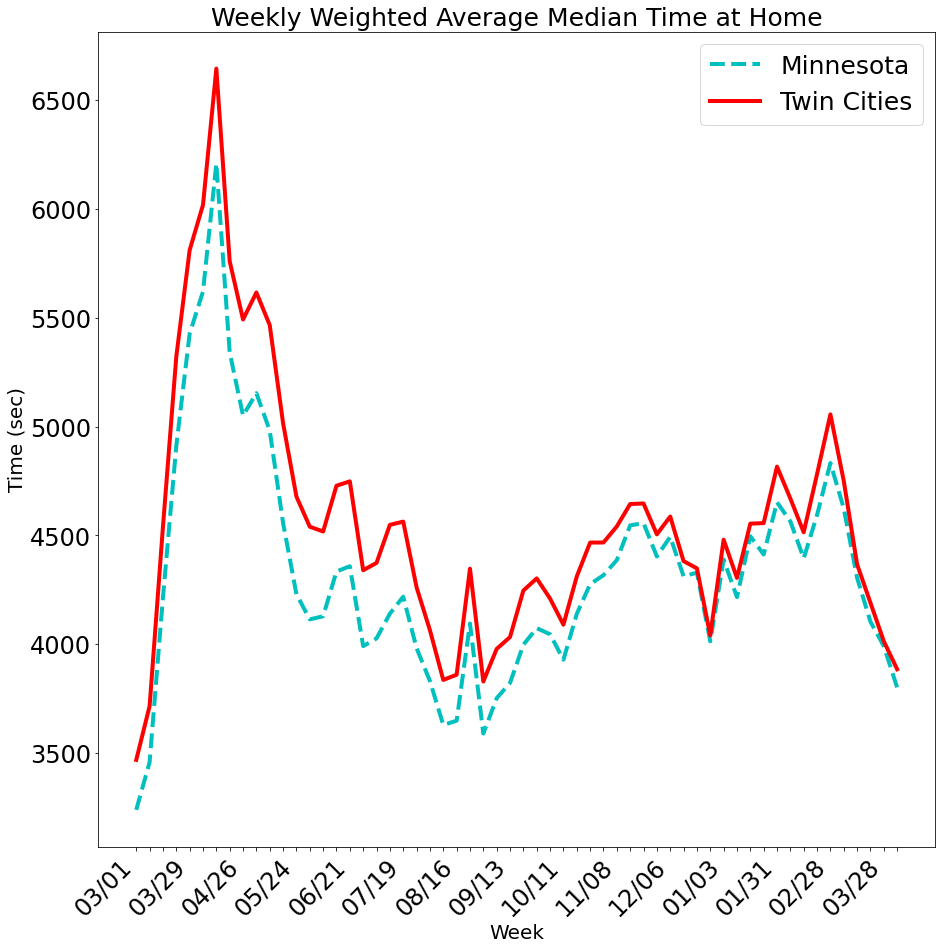

In [47]:
### Code for generating Figure 14a
state_avg_times = np.zeros(len(global_array[:-1])//7)
state_device_counts = np.zeros(len(global_array[:-1])//7)

metro_avg_times = np.zeros(len(global_array[:-1])//7)
metro_device_counts = np.zeros(len(global_array[:-1])//7)

plt_num = 0
for data in global_array[:-1]:
    state_avg_times[plt_num//7] += (data['avg_median_home_dwell_time'] * data['device_count']).sum() / data['device_count'].sum()
    
    metro_data = data.merge(metropolitan_ct_shp, left_on='ct_fips', right_on='GEOID')[data.columns]
    metro_avg_times[plt_num//7] += (metro_data['avg_median_home_dwell_time'] * metro_data['device_count']).sum() / metro_data['device_count'].sum()
    
    plt_num += 1

fig, ax = plt.subplots(1, 1, figsize=(15,15))
ax.set_title('Weekly Weighted Average Median Time at Home', {'fontsize': 25})
ax.set_xlabel('Week', {'fontsize': 20})
ax.set_ylabel('Time (sec)', {'fontsize': 20})
ax.set_xticks(list(range(len(global_array[:-1])//7)))
labels = []
for l_idx, l in enumerate(week_labels):
    if l_idx % 4 == 0:
        labels.append(l)
    else:
        labels.append('')
ax.set_xticklabels(labels,  {'fontsize': 24}, rotation = 45, ha="right")
ax.tick_params('y', labelsize=24)
ax.plot(state_avg_times, 'c--',linewidth=4, label='Minnesota')
ax.plot(metro_avg_times, 'r', linewidth=4, label='Twin Cities')
plt.legend(fontsize=25)
plt.show()

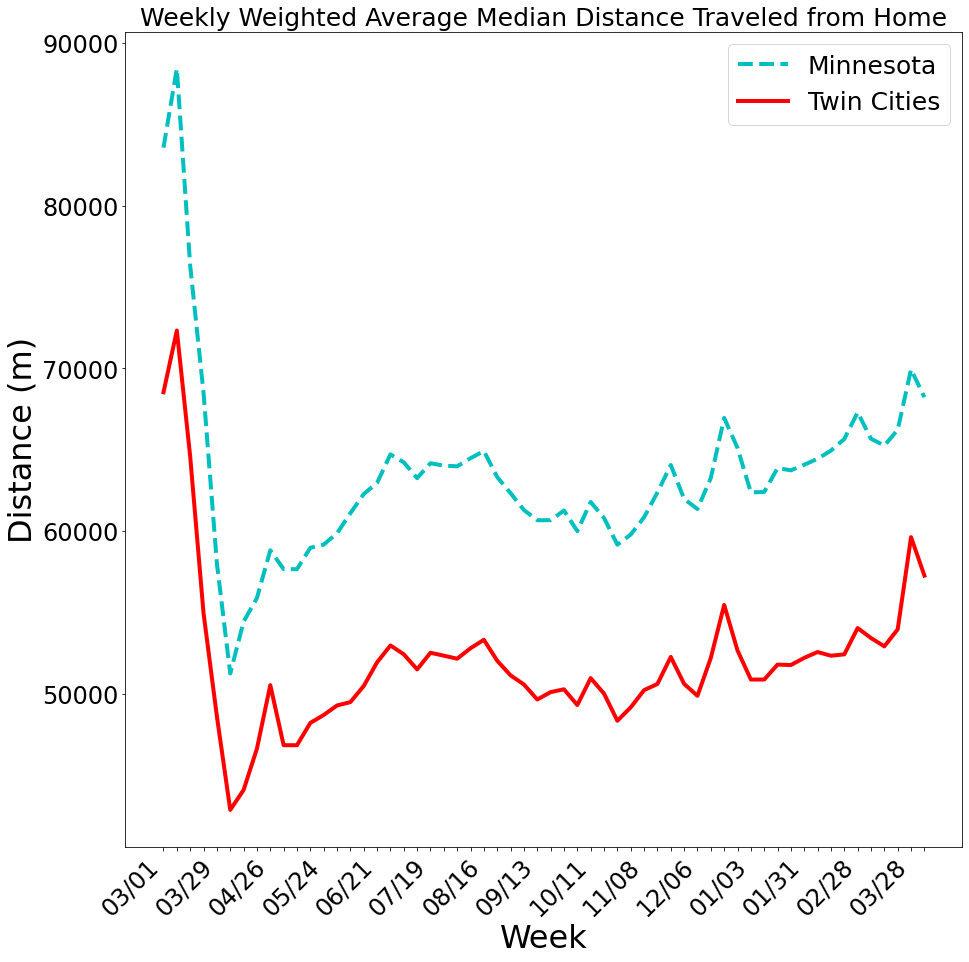

In [48]:
### Code for generating Figure 14b
fig, ax = plt.subplots(1, 1, figsize=(15,15))
ax.set_title('Weekly Weighted Average Median Distance Traveled from Home', {'fontsize': 25})
ax.set_xlabel('Week', {'fontsize': 32})
ax.set_ylabel('Distance (m)', {'fontsize': 32})
ax.set_xticks(list(range(len(global_array)//7)))
labels = []
for l_idx, l in enumerate(week_labels):
    if l_idx % 4 == 0:
        labels.append(l)
    else:
        labels.append('')
ax.set_xticklabels(labels,  {'fontsize': 24}, rotation = 45, ha="right")
ax.tick_params('y', labelsize=24)
ax.plot(state_avg_dists, 'c--', linewidth=4, label='Minnesota')
ax.plot(metro_avg_dists, 'r', linewidth=4, label='Twin Cities')
plt.legend(fontsize=25)
plt.show()

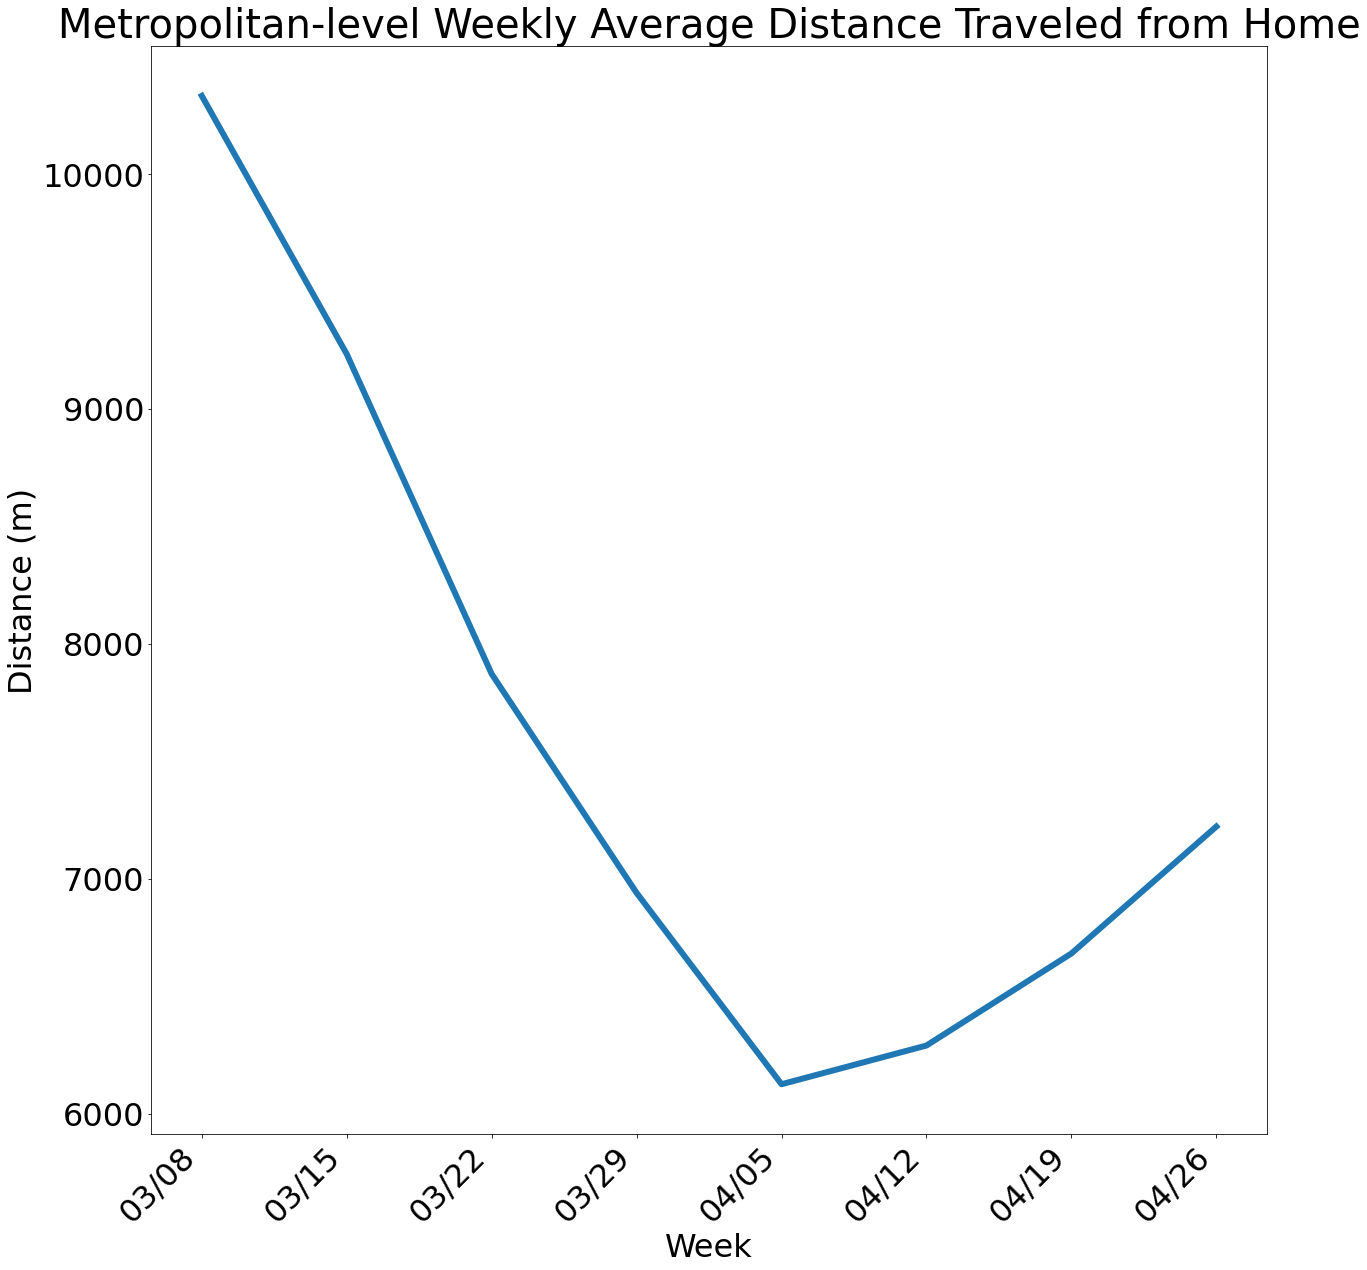

In [49]:
### Code for generating Figure 17a
avg_dists = np.zeros(len(global_array[:-1])//7)
device_counts = np.zeros(len(global_array[:-1])//7)

plt_num = 0
for data in global_array[:-1]:
    data = data.merge(metropolitan_ct_shp, left_on='ct_fips', right_on='GEOID')[data.columns]
    avg_dist = (data['avg_distance_traveled_from_home'] * data['device_count']).sum()
    avg_dists[plt_num//7] += avg_dist
    device_counts[plt_num//7] += data['device_count'].sum()
    plt_num += 1
    
avg_dists = avg_dists / device_counts

gap = avg_dists[9] - avg_dists[10]

for i in range(10, len(avg_dists)):
    avg_dists[i] += gap

fig, ax = plt.subplots(1, 1, figsize=(20,20))
ax.set_title('Metropolitan-level Weekly Average Distance Traveled from Home', {'fontsize': 40})
ax.set_xlabel('Week', {'fontsize': 32})
ax.set_ylabel('Distance (m)', {'fontsize': 32})
ax.set_xticks(list(range(len(global_array[1:])//7)))
ax.set_xticklabels(week_labels[1:9],  {'fontsize': 32}, rotation = 45, ha="right")
ax.tick_params('y', labelsize=32)
lines = ax.plot(avg_dists[1:9], linewidth=6)
plt.show()

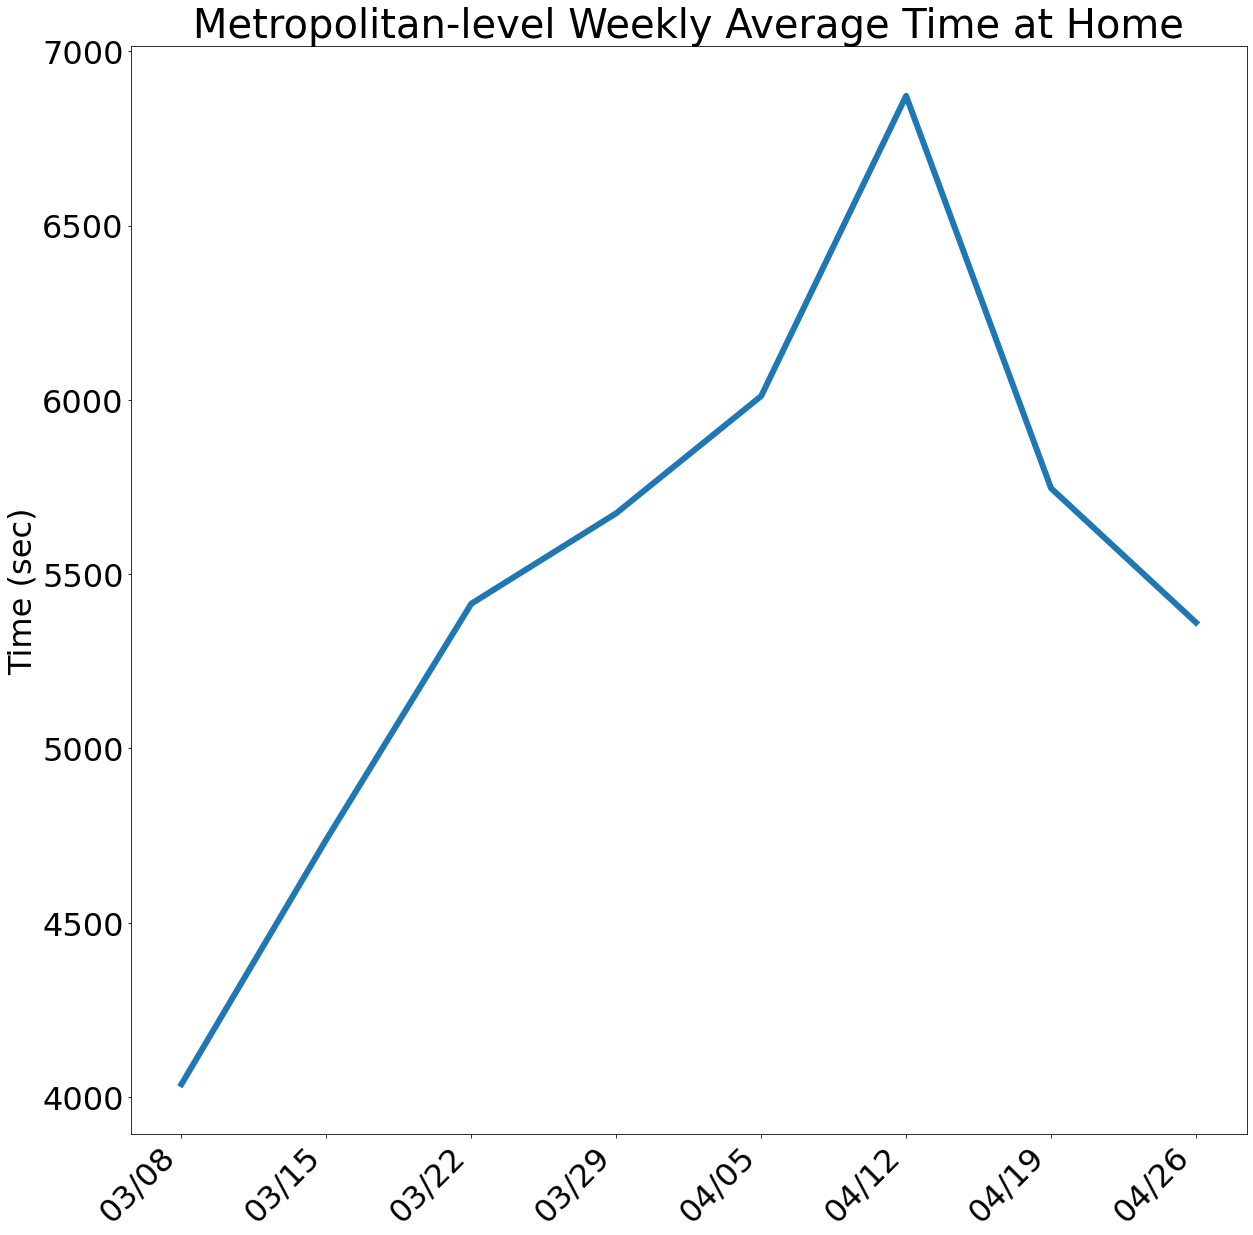

In [50]:
### Code for generating Figure 17b
avg_times = np.zeros(len(global_array[:-1])//7)
device_counts = np.zeros(len(global_array[:-1])//7)

plt_num = 0
for data in global_array[:-1]:
    data = data.merge(metropolitan_ct_shp, left_on='ct_fips', right_on='GEOID')[data.columns]
    avg_time = (data['avg_median_home_dwell_time'] * data['device_count']).sum()
    avg_times[plt_num//7] += avg_time
    device_counts[plt_num//7] = data['device_count'].sum()
    plt_num += 1
    
avg_times = avg_times / device_counts

fig, ax = plt.subplots(1, 1, figsize=(20,20))
ax.set_title('Metropolitan-level Weekly Average Time at Home', {'fontsize': 40})
# ax.set_xlabel('Week', {'fontsize': 32})
ax.set_ylabel('Time (sec)', {'fontsize': 32})
ax.set_xticks(list(range(len(global_array[:-1])//7)))
ax.set_xticklabels(week_labels[1:9],  {'fontsize': 32}, rotation = 45, ha="right")
ax.tick_params('y', labelsize=32)
lines = ax.plot(avg_times[1:9], linewidth=6)
plt.show()